# 使用Mac的GPU跑神经网络

TensorFlow 和 PyTorch 等深度学习的开源代码，一般只能运行在 NVIDIA 的 GPU 上，对于 Mac 上的 AMD 的 GPU 并不支持。使用 Intel 推出的开源代码库 PlaidML，可以使得深度学习的代码也可以运行在 MacOS 上。

这里，我们可以在 Python 的环境中使用下面的命令来安装它：

```pip install plaidml-keras```

完成安装后，还需要让代码适配本机的 GPU 。使用下面的代码来进行配置：

```plaidml-setup```

![](images/plaidml_setup_0.png)

在给出的选项里选择不支持实验性的设备。目前的笔记本为 MacBook Pro 2019版 16寸，在下面的选项里选择默认设备为 AMD 的 GPU ，并保存设置文件：

![](images/plaidml_setup_1.png)

使用下面的代码，就可以让 Keras 的默认后端为 PlaidML，代替默认的 TensorFlow：

In [3]:
import plaidml.keras
plaidml.keras.install_backend()
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

为了测试GPU的效率和代码的正确性，可以在 MNIST 数据集市上跑一个标准的小型CNN代码，代码下载地址为： https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [4]:
def test_speed_of_device(use_tensorflow = False):
    '''Trains a simple convnet on the MNIST dataset.
    Gets to 99.25% test accuracy after 12 epochs
    (there is still a lot of margin for parameter tuning).
    16 seconds per epoch on a GRID K520 GPU.
    '''

    #from __future__ import print_function
    if use_tensorflow:
        from tensorflow import keras
        from tensorflow.keras.datasets import mnist
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import Dense, Dropout, Flatten
        from tensorflow.keras.layers import Conv2D, MaxPooling2D
        from tensorflow.keras import backend as K
    else:
        import keras
        from keras.datasets import mnist
        from keras.models import Sequential
        from keras.layers import Dense, Dropout, Flatten
        from keras.layers import Conv2D, MaxPooling2D
        from keras import backend as K

    batch_size = 128
    num_classes = 10
    epochs = 12

    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

8个CPU在PlaidML中运行一个epoch的时间为2140s，运行时间比较慢：

In [ ]:
os.environ["PLAIDML_DEVICE_IDS"] = "llvm_cpu.0"
test_speed_of_device()

Intel的集成显卡运行时间为122s,并且运行结果并不正确：

In [3]:
os.environ["PLAIDML_DEVICE_IDS"] = "metal_intel(r)_uhd_graphics_630.0"
test_speed_of_device()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


INFO:plaidml:Opening device "metal_intel(r)_uhd_graphics_630.0"


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 131s 2ms/step - loss: nan - acc: 0.0988 - val_loss: nan - val_acc: 0.0980
Epoch 2/3
60000/60000 [==============================] - 134s 2ms/step - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 3/3
60000/60000 [==============================] - 122s 2ms/step - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Test loss: nan
Test accuracy: 0.098


AMD显卡GPU的运行时间为14s：

In [5]:
#os.environ["PLAIDML_EXPERIMENTAL"] = "False"
os.environ["PLAIDML_DEVICE_IDS"] = "metal_amd_radeon_pro_5500m.0"
test_speed_of_device()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


INFO:plaidml:Opening device "metal_amd_radeon_pro_5500m.0"


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 15s 252us/step - loss: 0.2645 - acc: 0.9191 - val_loss: 0.0648 - val_acc: 0.9786
Epoch 2/12
60000/60000 [==============================] - 14s 236us/step - loss: 0.0901 - acc: 0.9736 - val_loss: 0.0412 - val_acc: 0.9861
Epoch 3/12
60000/60000 [==============================] - 14s 237us/step - loss: 0.0677 - acc: 0.9803 - val_loss: 0.0332 - val_acc: 0.9890
Epoch 4/12
60000/60000 [==============================] - 14s 236us/step - loss: 0.0569 - acc: 0.9836 - val_loss: 0.0308 - val_acc: 0.9900
Epoch 5/12
60000/60000 [==============================] - 14s 240us/step - loss: 0.0501 - acc: 0.9851 - val_loss: 0.0308 - val_acc: 0.9893
Epoch 6/12
60000/60000 [==============================] - 14s 241us/step - loss: 0.0425 - acc: 0.9870 - val_loss: 0.0289 - val_acc: 0.9900
Epoch 7/12
60000/60000 [==============================] - 14s 242us/step - loss: 0.0378 - acc: 0.9886 - val_loss: 0.

可以看到在TensorFlow2.0中8个CPU的情况下， 网络运行一个epoch的时间约为64s，单个CPU的运行时间约为512s：

In [3]:
test_speed_of_device(use_tensorflow = True)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 72s 1ms/sample - loss: 2.2901 - accuracy: 0.1454 - val_loss: 2.2715 - val_accuracy: 0.3572
Epoch 2/12
60000/60000 [==============================] - 75s 1ms/sample - loss: 2.2605 - accuracy: 0.2444 - val_loss: 2.2341 - val_accuracy: 0.5318
Epoch 3/12
60000/60000 [==============================] - 70s 1ms/sample - loss: 2.2202 - accuracy: 0.3416 - val_loss: 2.1836 - val_accuracy: 0.6062
Epoch 4/12
60000/60000 [==============================] - 71s 1ms/sample - loss: 2.1647 - accuracy: 0.4164 - val_loss: 2.1115 - val_accuracy: 0.6468
Epoch 5/12
60000/60000 [==============================] - 71s 1ms/sample - loss: 2.0862 - accuracy: 0.4709 - val_loss: 2.0081 - val_accuracy: 0.6786
Epoch 6/12
60000/60000 [==============================] - 69s 1ms/sample - loss: 1.9775 - accuracy: 0.5102 - val_loss: 1.8648 - val_

TensorFlow2.0的权值初始化方式与Keras的初始化方式并不相同，导致了跑出的结果反而差异比较大。

可以看到单个GPU对比单个CPU获得了大约36倍的加速：

Populating the interactive namespace from numpy and matplotlib


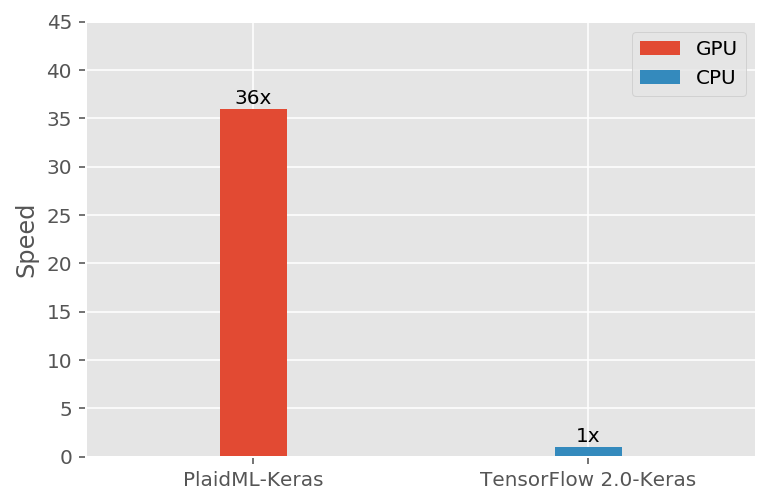

In [6]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
mpl.style.use('ggplot')

 
plt.bar('PlaidML-Keras', 36,  label='GPU',width=0.2)
plt.bar('TensorFlow 2.0-Keras', 1, label='CPU',width=0.2)
plt.ylabel('Speed')
plt.xlim([-0.5,1.5])
plt.ylim([0,45])
plt.text('PlaidML-Keras', 36 + 0.1, '36x',horizontalalignment='center',verticalalignment='bottom')  
plt.text('TensorFlow 2.0-Keras', 1 + 0.1, '1x', ha='center', va='bottom')
plt.legend()
plt.show()